# Imports

In [ ]:
import sys
!{sys.executable} -m pip install transformers datasets tokenizers evaluate
!{sys.executable} -m pip install requests nlpaug
import datasets
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [58]:
data = datasets.load_dataset('webis/Touche23-ValueEval')
label_values = ["Self-direction: thought", "Self-direction: action", "Stimulation", "Hedonism", "Achievement", "Power: dominance", "Power: resources", "Face", "Security: personal", "Security: societal", "Tradition", "Conformity: rules", "Conformity: interpersonal", "Humility", "Benevolence: caring", "Benevolence: dependability", "Universalism: concern", "Universalism: nature", "Universalism: tolerance", "Universalism: objectivity"]
data["training"].to_pandas().head()


Using custom data configuration webis--Touche23-ValueEval-6979f60cf05ee731
Found cached dataset csv (/Users/lisakoopmans/.cache/huggingface/datasets/webis___csv/webis--Touche23-ValueEval-6979f60cf05ee731/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/3 [00:00<?, ?it/s]

,Argument ID,Conclusion,Stance,Premise,Labels
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]"
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]"
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0]"
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0]"
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0]"


# Pre-processing

In [16]:
def labels_to_list(labels_string):
    return np.array([int(label) for label in labels_string[1:-1].split(',')])

data_train = data['training'].to_pandas()
data_train['Labels'] = data_train['Labels'].map(lambda x: labels_to_list(x))

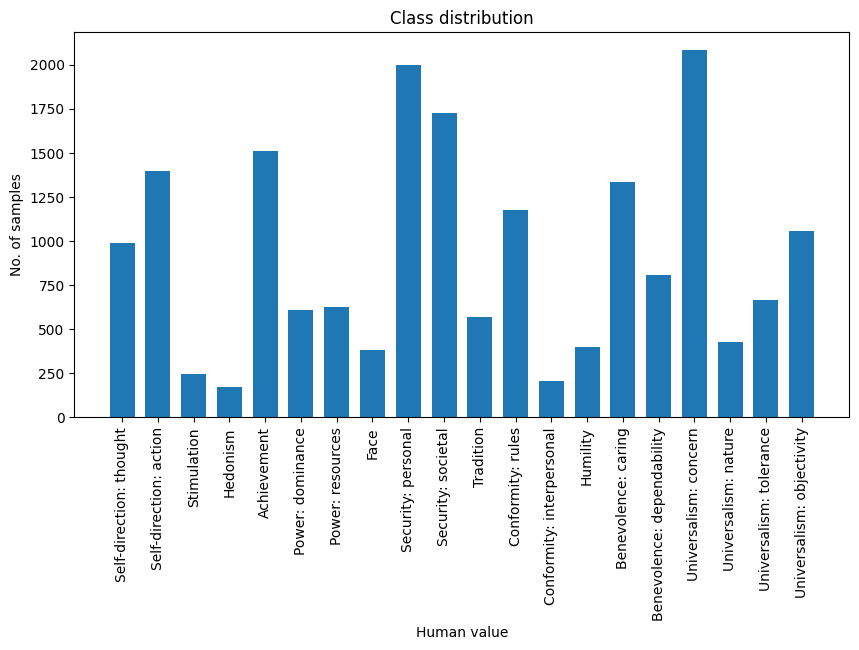

In [26]:
data_counts = data_train['Labels'].sum(axis=0)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(label_values, data_counts,
        width = 0.7)
 
plt.xlabel("Human value")
plt.xticks(rotation='vertical')
plt.ylabel("No. of samples")
plt.title("Class distribution")
plt.show()

### Data augmentation

In [ ]:
trans_en_ru = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-en-ru")
trans_ru_en = pipeline("text2text-generation", model="Helsinki-NLP/opus-mt-ru-en")

def rus_back_trans(text, trans_to, trans_back):
    aug_sent = trans_back(trans_to(text)[0]['generated_text'])
    return aug_sent[0]['generated_text']

augmentations = []
i = 0
premises = data_train['Premise']
for premise in premises:
    if i % 100 == 0: print(i)
    augmentations.append(rus_back_trans(premise, trans_en_ru, trans_ru_en))
    i += 1



In [74]:
np.save('./back_trans_augm.npy', augmentations)
data_train['Rus-back-trans'] = np.load('./back_trans_augm.npy')
data_train.head()

,Argument ID,Conclusion,Stance,Premise,Labels,Rus-back-trans
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","We must ban human cloning, because it will cau..."
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Rapid food must be banned because it is very u...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",The death penalty is sometimes the only way to...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",Farms produce the cheap food needed for low-in...


In [56]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

stopWords = set(stopwords.words('english'))

text = data['training'][0]['Premise']
# text = probes[0]['generated_text']
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.4, stopwords=stopWords)
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.
Augmented Text:
['we should blackball human cloning as it will only make vast government issue when you have a gang of the same human race race approximately all act the same.']


In [ ]:
from transformers import pipeline
paraphraser = pipeline("text2text-generation", model="humarin/chatgpt_paraphraser_on_T5_base")

phrase_ex = data['training'][0]['Premise']
num_paraphrased = 1
probes = paraphraser(phrase_ex, num_return_sequences=num_paraphrased)
print(phrase_ex)
print(probes[0])
